# EMCAL studies in DQ

## Acceptance
###  (Cristina) 
As a first estimate, count the number of events that has two reconstructed clusters in the EMCAL. Do this for a given coupling (i.e. fixed lifetime) and different A' masses for one production mechanism first.

## 1. Clustering
###  (Cristina & Sergio) 
We want to perform dummy clustering. For now, both Birch and k-means cluster for a given number of clusters. There is also algommerative clustering which might work best to get clusters around high energy deposits. We can use the simhit x and y derived from the tower ID and use the 5cm as a bin resolution.

- Draw a couple of clustering scenarios
- Get energy deposits of clusters and compare with sim energy of electron.
- Plot energy weighted position of the towers vs electron sim energy.
- Plot the size of these clusters

## 2. EMCAL kinematics
###  (Sergio) 

We also want to understand the kick from the magnet to electrons that reach the EMCAL. For this we can compute the skew (distance in dx, dy, dR) between the true simHit position in H2 and the one in EMCAL.

- Get dR between simhit position in H2 and simHit position in EMCAL. Plot it as a function of electron sim energy.

## 3. "Reconstruct" Electrons
###  (Sergio) 
- Plot reconstructed energy distribution for electrons (should look like a gaussian) and take the mean ($<E>$) and sigma ($\sigma_E$).
- Plot ($\sigma_E/<E>$) as a function of the electron sim Energy.

In [1]:
import uproot
import numpy as np
import numba
import awkward1 as ak
import awkward as ak0

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import                                                                                                                  
import mplhep as hep
plt.style.use(hep.style.ROOT)
import os,sys
import pandas as pd
from scipy.stats import halfnorm

In [3]:
def getData(fname="", procName="Truth"):
    dq_dict = uproot.open(fname)["Truth"].arrays()
    dq_dict_ak1 = {name.decode(): ak.from_awkward0(array) for name, array in dq_dict.items()}
    dq_events = ak.zip({"Hits":ak.zip({
                                      "detID":   dq_dict_ak1["hit_detID"],
                                      "edep":    dq_dict_ak1["hit_edep"],
                                      "elmID":   dq_dict_ak1["hit_elmID"],
                                      "truthx":  dq_dict_ak1["hit_truthx"],
                                      "truthy":  dq_dict_ak1["hit_truthy"],
                                      "truthz":  dq_dict_ak1["hit_truthz"],
                                      }),
                        "Electrons":ak.zip({
                                            "ge":      dq_dict_ak1["ge"],
                                        }),
                       }, depth_limit=1)
    return dq_events

In [4]:
def emcal_selection(arr):
    mask = (arr.detID == 100)
    return mask

def h2_selection(arr):
    mask = (arr.detID >= 35) & (arr.detID <= 38)
    return mask

def st2_selection(arr):
    mask = (arr.detID >= 13) & (arr.detID <= 18)
    return mask

def st3_selection(arr):
    mask = (arr.detID >= 19) & (arr.detID <= 30)
    return mask

def h4_selection(arr):
    mask = (arr.detID >= 41) & (arr.detID <= 46)
    return mask

In [5]:
def printemcalhits_byevent(ifile):
    dq_events = getData(ifile,"Truth")
    dq_hits = dq_events["Hits"]
    ecal_mask = ak.any(dq_hits.detID == 100, axis=1)
    ecal_index = np.where(ecal_mask)
    print('Fraction of events with hits reaching EMCAL: ',len(ecal_index[0])/len(dq_events))
    print("Let's print the evt numbers we can use to plot EMCAL clusters")
    print('Indices of evts w. EMCAL hits:',ecal_index)

In [165]:
def emcal_byevent(ifile,evtNum):
    Mass=ifile.split("_")[3]+" GeV"
    Type=ifile.split("_")[2]
    
    #EMCAL
    ntowersx=72
    ntowersy=36
    sizex=5.53 # in cm
    sizey=5.53 # in cm

    ecalx=[-200,200] #size in cm
    ecaly=[-100,100]
    binsx=ecalx[1]-ecalx[0]
    binsy=ecaly[1]-ecaly[0]

    dq_events = getData(ifile,"Truth")
    dq_hits = dq_events[evtNum]["Hits"]
    dq_electrons = dq_events[evtNum]["Electrons"]
    
    ge = dq_electrons.ge
    
    emcal_mask = emcal_selection(dq_hits)
    emcal_hits = dq_hits[emcal_mask]
    emcal_towerx = emcal_hits.elmID//ntowersy
    emcal_towery = emcal_hits.elmID%ntowersy
    emcal_truthx = emcal_hits.truthx
    emcal_truthy = emcal_hits.truthy
    emcal_x = ecalx[0]+emcal_towerx*sizex
    emcal_y = ecaly[0]+emcal_towery*sizey
    emcal_edep = emcal_hits.edep
    
    st3_mask = st3_selection(dq_hits)
    st3_hits = dq_hits[st3_mask]

    st2_mask = st2_selection(dq_hits)
    st2_hits = dq_hits[st2_mask]
    st2_truthx = st2_hits.truthx
    st2_truthy = st2_hits.truthy
    
    h2_mask = h2_selection(dq_hits)
    h2_hits = dq_hits[h2_mask]
    
    print("St3 hits %i, St2 hits %i, H2 hits %i"%(len(st3_hits),len(st2_hits),len(h2_hits)))
    print("Event "+str(evtNum)+": "+str(len(emcal_hits))+" hits")
    
    # Plot x and y from towers
    fig = plt.figure(figsize=(8,6))
    plt.hist2d(np.array(emcal_x),np.array(emcal_y), bins=[int(binsx/sizex),int(binsy/sizey)], range=[ecalx,ecaly], density=False)
    plt.xlabel("Tower x")
    plt.ylabel("Tower y")
    cbar=plt.colorbar()
    cbar.set_label('Counts')
    plt.title("Unweighted Counts for "+Type+": "+Mass+" \n Event "+str(evtNum))
    plt.show()

    # weighted
    fig = plt.figure(figsize=(8,6))
    plt.hist2d(np.array(emcal_x),np.array(emcal_y), bins=[int(binsx/sizex),int(binsy/sizey)], range=[ecalx,ecaly], weights=np.array(emcal_edep), density=False)
    plt.xlabel("Tower x")
    plt.ylabel("Tower y")
    cbar=plt.colorbar()
    cbar.set_label('Energy Deposit [MeV]')
    plt.title("Energy Deposits for "+Type+": "+Mass+" \n Event "+str(evtNum))
    plt.show()
    
    # clustering
    X = np.vstack((np.array(emcal_x), np.array(emcal_y))).T
    print('X t',X)
    print(np.array(emcal_x))
    print(np.array(emcal_y))
    #X = np.vstack((np.array(emcal_x), np.array(emcal_y)), axis=-1)
    #print('X ',X)
    
    # try birch clusters without considering weights by energy
    from sklearn.cluster import Birch
    from sklearn.mixture import GaussianMixture
    from numpy import unique
    from numpy import where
    X = np.vstack((np.array(emcal_x), np.array(emcal_y))).T
    brc = Birch(n_clusters=2)
    brc.fit(X)
    yhat = brc.predict(X)
    clusters = unique(yhat)
    # create scatter plot for samples from each cluster
    fig = plt.figure(figsize=(8,6))
    for cluster in clusters:
        # get row indexes for samples with this cluster
        row_ix = where(yhat == cluster)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1])
    # show the plot
    plt.xlabel("EMCAL x")
    plt.ylabel("EMCAL y")
    plt.xlim(ecalx[0],ecalx[1])
    plt.ylim(ecaly[0],ecaly[1])
    plt.show()    
    
    # energy weights
    print('max edep',np.max(emcal_edep),np.max(emcal_edep).shape)
    print('emcal_edep',emcal_edep,emcal_edep.shape)
    energy_weights = np.divide(np.array(emcal_edep),np.max(emcal_edep))
    print('e weig',energy_weights,energy_weights.shape)   
    
    # try kmeans clusters with energy weights
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000)
    X = np.vstack((np.array(emcal_x), np.array(emcal_y))).T
    Y = energy_weights
    wt_kmeansclus = kmeans.fit(X,sample_weight = Y)
    predicted_kmeans = kmeans.predict(X, sample_weight = Y)
    # create scatter plot 
    fig = plt.figure(figsize=(8,6))
    plt.scatter(X[:,0], X[:,1], c=wt_kmeansclus.labels_.astype(float),s=10,cmap='tab20b',marker='x')
    plt.title('Ecal clusters - Weighted K-Means')
    plt.xlabel('EMCAL x')
    plt.ylabel('EMCAL y')
    centers = wt_kmeansclus.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=500, alpha=0.5);
    plt.xlim(ecalx[0],ecalx[1])
    plt.ylim(ecaly[0],ecaly[1])
    plt.show()
    # print cluster 
    print(wt_kmeansclus)
    # this is one cluster
    clus_0 = X[wt_kmeansclus.labels_==0]
    clus_1 = X[wt_kmeansclus.labels_==1]
    
    # try dbscan
    from sklearn.cluster import DBSCAN
    from sklearn import metrics
    X = np.vstack((np.array(emcal_x), np.array(emcal_y))).T
    print('x',X)
    print('energy weights',energy_weights.shape,' x',X.shape, 'x len', len(X))
    print(energy_weights.shape,np.ones(X.shape[1]).shape,np.ones(len(X)).shape)
    
    from sklearn.neighbors import DistanceMetric
    # Inputs: a and b are rows from a data matrix   
    def wminkowski(u, v, p, w):
        dist = norm(w * (u - v), ord=p)
        return dist
    dist = DistanceMetric.get_metric('wminkowski',p=2,w=energy_weights)
    print(dist)
    neigh = NearestNeighbors(n_neighbors=2, metric=lambda x,y: wminkowski(a,b,L))
    """
    from sklearn.neighbors import NearestNeighbors
    #dist = pdist(X, 'wminkowski', p=2, w=energy_weights)
    #print(dist)
    #print(dist.pairwise(X))

    neigh = NearestNeighbors(n_neighbors=2, metric=dist)
    print(neigh)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    """
    db = DBSCAN(eps=50, min_samples=1).fit(X)
    labels = db.labels_
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    
    # Black removed and is used for noise instead.
    fig = plt.figure(figsize=(8,6))
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
        class_member_mask = (labels == k)
        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)
        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
    plt.xlabel('EMCAL x')
    plt.ylabel('EMCAL y')
    plt.xlim(ecalx[0],ecalx[1])
    plt.ylim(ecaly[0],ecaly[1])
    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
    # try hierarchy clustering
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html
    # https://stackoverflow.com/questions/21638130/tutorial-for-scipy-cluster-hierarchy 
    from scipy.cluster.hierarchy import weighted, fcluster 
    from scipy.spatial.distance import pdist
    X = np.vstack((np.array(emcal_x), np.array(emcal_y))).T
    # weighted minkowski metric
    Y = pdist(X, 'wminkowski', p=2, w=energy_weights)
    print(Y)
    # this is a linkage matrix containing the hierarchical clustering where we have considered the minkowski metric w sim energy as weights
    Z = weighted(Y)
    
    # this is the screening plot
    fig = plt.figure(figsize=(8,6))
    plt.plot(range(1, len(Z)+1), Z[::-1, 2])
    # here you take the derivative, 
    # the number on the abscissa is one possible solution which consists of the according number of partitions
    # Now, the more partitions you allow, the higher the homogenity within the clusters will be. 
    # So what you actually want is: Low number of partitions with high homogenity (in most cases). This is why you look for the "knee" point, i. e. the point before the distance value "jumps" to a much higher value in relation to the increase before.
    knee = np.diff(Z[::-1, 2], 2)
    plt.plot(range(2, len(Z)), knee)
    plt.ylabel('Cluster distance')
    plt.xlabel('Partition')
        
    try:
        num_clust1 = knee.argmax() + 2
        knee[knee.argmax()] = 0
        num_clust2 = knee.argmax() + 2
    except:
        print('not able to create > 1 clusters')
        print('knee ',knee)
        print('max of energies ',np.max(np.array(emcal_edep)))
        return
    
    plt.text(num_clust1, Z[::-1, 2][num_clust1-1], 'possible\n<- knee point')
    plt.show()
    
    # these are the two partitions based on the number of clusters 
    # maxclust will find a minimum threshold r so that the cophenetic distance 
    # between any two original observations in the same flat cluster 
    # is no more than r and no more than t flat clusters are formed.
    part1 = fcluster(Z, num_clust1, 'maxclust')
    part2 = fcluster(Z, num_clust2, 'maxclust')

    # plot the two different partitions
    for part, numclust in zip([part1, part2], [num_clust1,num_clust2]):
        fig = plt.figure(figsize=(8,6))
        for cluster in set(part):
            plt.scatter(X[part == cluster, 0], X[part == cluster, 1])
        method = 'Distance weighted Minkowski'
        m = '\n(method: {})'.format(method)
        plt.title('{} Clusters'.format(numclust))
        plt.xlabel('EMCAL x')
        plt.ylabel('EMCAL y')
        plt.xlim(ecalx[0],ecalx[1])
        plt.ylim(ecaly[0],ecaly[1])
        plt.show()
        
        # let's print also the index of clusters for when num_clust = 2
        if(numclust == 2):
            # because the energy array has the same shape as X, we can do a mask of those indices
            sum_energies = []
            size_clusters = []
            for cluster in set(part):
                energy_clust = np.array(emcal_edep[part == cluster])
                sum_energies.append(np.sum(energy_clust))
            print('sum energy ',sum_energies)
            print('energy of electrons (genE) ', ge)
            print('size of clusters ?')

Fraction of events with hits reaching EMCAL:  0.9666
Let's print the evt numbers we can use to plot EMCAL clusters
Indices of evts w. EMCAL hits: (<Array [0, 1, 2, 3, ... 9996, 9997, 9998, 9999] type='9666 * int64'>,)
St3 hits 0, St2 hits 12, H2 hits 4
Event 9998: 55 hits


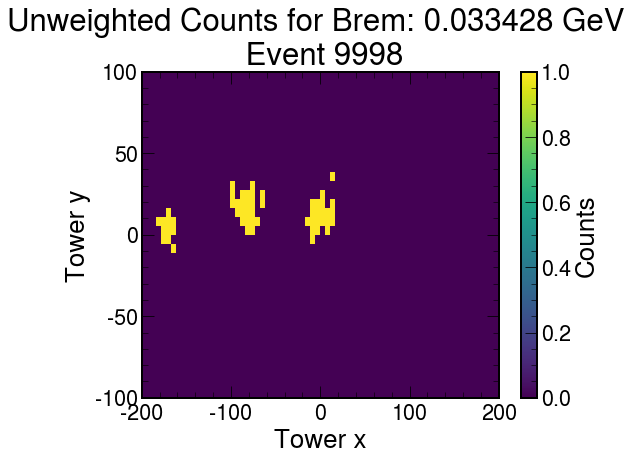

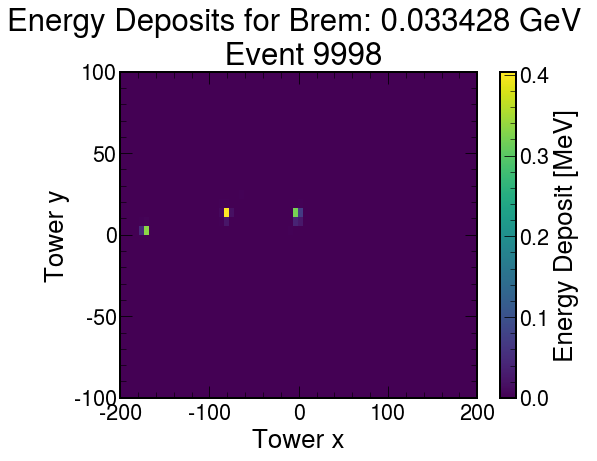

X t [[-177.88   10.6 ]
 [-172.35   -0.46]
 [-172.35    5.07]
 [-172.35   10.6 ]
 [-166.82   -0.46]
 [-166.82    5.07]
 [-166.82   10.6 ]
 [-166.82   16.13]
 [-161.29   -5.99]
 [-161.29    5.07]
 [-161.29   10.6 ]
 [ -94.93   21.66]
 [ -94.93   27.19]
 [ -94.93   32.72]
 [ -89.4    16.13]
 [ -89.4    21.66]
 [ -83.87   10.6 ]
 [ -83.87   16.13]
 [ -83.87   21.66]
 [ -83.87   27.19]
 [ -78.34    5.07]
 [ -78.34   10.6 ]
 [ -78.34   16.13]
 [ -78.34   21.66]
 [ -78.34   27.19]
 [ -72.81    5.07]
 [ -72.81   10.6 ]
 [ -72.81   16.13]
 [ -72.81   21.66]
 [ -72.81   27.19]
 [ -72.81   32.72]
 [ -67.28   10.6 ]
 [ -61.75   21.66]
 [ -61.75   27.19]
 [ -11.98   10.6 ]
 [  -6.45   -0.46]
 [  -6.45    5.07]
 [  -6.45   10.6 ]
 [  -6.45   16.13]
 [  -6.45   21.66]
 [  -0.92    5.07]
 [  -0.92   10.6 ]
 [  -0.92   16.13]
 [  -0.92   21.66]
 [   4.61   10.6 ]
 [   4.61   16.13]
 [   4.61   21.66]
 [   4.61   27.19]
 [  10.14    5.07]
 [  10.14   10.6 ]
 [  10.14   16.13]
 [  15.67   10.6 ]
 [  15.6

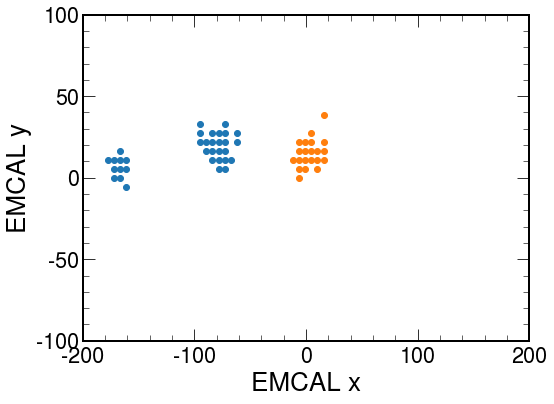

max edep 0.40395948 ()
emcal_edep [0.000224, 0.00126, 0.0462, 0.00239, ... 0.000368, 0.000733, 0.00044, 0.000315] (55,)
e weig [5.54375642e-04 3.11828032e-03 1.14276655e-01 5.90610597e-03
 3.86601430e-03 8.25509965e-01 9.50935297e-03 1.22524030e-03
 1.56805839e-03 2.67701829e-03 2.23239814e-03 5.67731273e-04
 6.30663359e-04 3.45995184e-03 9.18251870e-04 1.62497186e-03
 5.17604966e-03 2.19399650e-02 6.49429299e-03 1.27420109e-03
 1.07353444e-04 5.49367070e-02 1.00000000e+00 5.98422950e-03
 9.95138776e-04 2.00832891e-03 2.73185316e-03 4.01182137e-02
 3.09266092e-04 1.79201702e-03 9.65783780e-04 1.92943029e-04
 3.54019855e-03 6.02606544e-03 6.59120968e-04 3.07528395e-03
 4.49149404e-03 2.32179373e-04 1.01604499e-03 8.71520431e-04
 3.23711138e-05 9.73361582e-02 7.95342565e-01 3.81148384e-05
 6.39449880e-02 1.73222795e-01 4.72455472e-03 2.50485260e-03
 1.69906387e-04 3.04283574e-04 1.57335051e-03 9.11169220e-04
 1.81342440e-03 1.08934415e-03 7.79432128e-04] (55,)


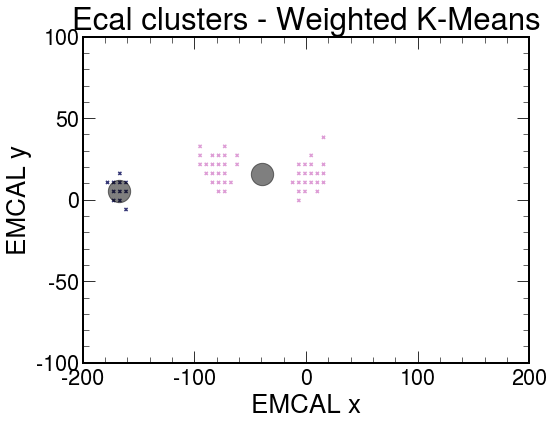

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
x [[-177.88   10.6 ]
 [-172.35   -0.46]
 [-172.35    5.07]
 [-172.35   10.6 ]
 [-166.82   -0.46]
 [-166.82    5.07]
 [-166.82   10.6 ]
 [-166.82   16.13]
 [-161.29   -5.99]
 [-161.29    5.07]
 [-161.29   10.6 ]
 [ -94.93   21.66]
 [ -94.93   27.19]
 [ -94.93   32.72]
 [ -89.4    16.13]
 [ -89.4    21.66]
 [ -83.87   10.6 ]
 [ -83.87   16.13]
 [ -83.87   21.66]
 [ -83.87   27.19]
 [ -78.34    5.07]
 [ -78.34   10.6 ]
 [ -78.34   16.13]
 [ -78.34   21.66]
 [ -78.34   27.19]
 [ -72.81    5.07]
 [ -72.81   10.6 ]
 [ -72.81   16.13]
 [ -72.81   21.66]
 [ -72.81   27.19]
 [ -72.81   32.72]
 [ -67.28   10.6 ]
 [ -61.75   21.66]
 [ -61.75   27.19]
 [ -11.98   10.6 ]
 [  -6.45   -0.46]
 [  -6.45    5.07]
 [  -6.45   10.6 ]
 [  -6.45   16.13]
 [  -6.45   21.66]
 [  -0.92    5.07]
 [  -0.92   10.6 ]
 [  -0.92   16.

NameError: name 'NearestNeighbors' is not defined

In [166]:
ifileBrem = "sim_eval_Brem_0.033428_z500_600_eps_-5.2.root"
# this prints the evt numbers w emcal hits and returns basic acceptance
acc = printemcalhits_byevent(ifileBrem)
# this reconstructs preliminary clusters
emcal_byevent(ifileBrem,9998)

Fraction of events with hits reaching EMCAL:  0.315
Let's print the evt numbers we can use to plot EMCAL clusters
Indices of evts w. EMCAL hits: (<Array [0, 18, 21, 22, ... 9987, 9993, 9999] type='3150 * int64'>,)
St3 hits 0, St2 hits 12, H2 hits 4
Event 0: 25 hits


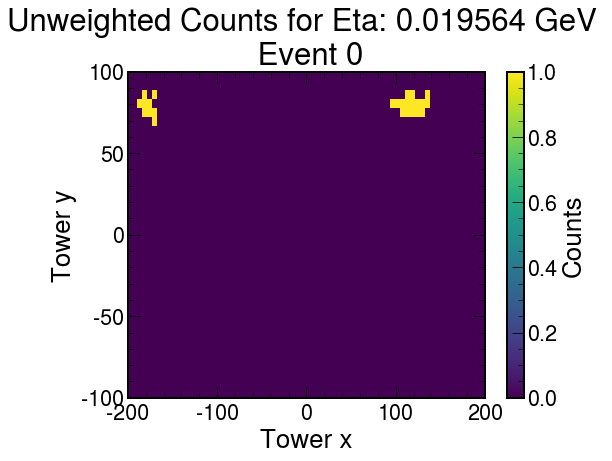

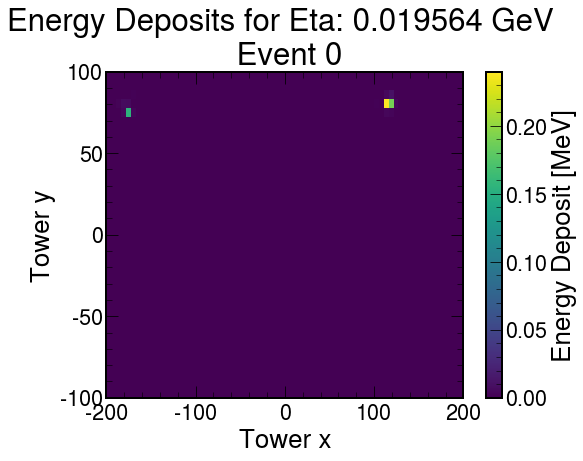

sum edep 0.6418281 ()
emcal_edep [0.00231, 0.00461, 0.00666, 0.000199, ... 0.000383, 0.000498, 0.000291, 0.000854] (25,)
e weig [0.0036, 0.00718, 0.0104, 0.000311, 0.241, ... 0.000596, 0.000776, 0.000453, 0.00133] (25,)


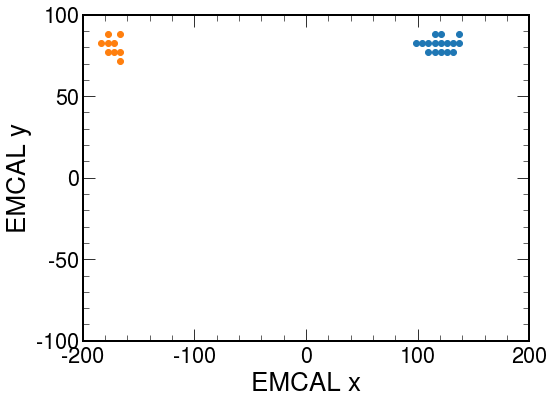

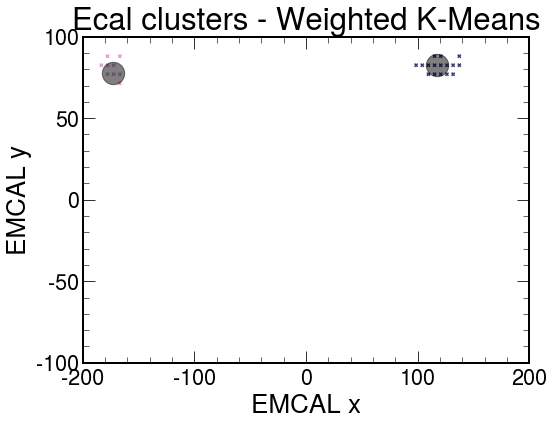

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=1000,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)
energy weights (25,) (2, 25)
(25,) (25,)
Estimated number of clusters: 2
Estimated number of noise points: 0


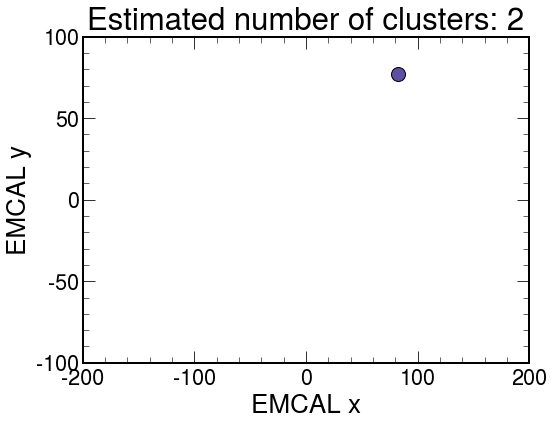

[0.02848918 0.0127687  0.02848918 0.03606594 0.02553739 0.06373171
 0.04599946 0.04599946 0.6512035  0.66397219 0.67721992 0.67674089
 0.68997975 0.68950958 0.68997975 0.70273991 0.70227828 0.70273991
 0.71550036 0.71504698 0.72826111 0.72781567 0.74058437 0.74102213
 0.0254675  0.050935   0.0127687  0.02848918 0.03606594 0.02553739
 0.05697835 0.63894255 0.6517013  0.66397219 0.66446043 0.67674089
 0.67721992 0.678655   0.68950958 0.68997975 0.69138834 0.70227828
 0.70273991 0.71504698 0.71550036 0.72826111 0.7295958  0.0254675
 0.02848918 0.0127687  0.05697835 0.03606594 0.03606594 0.6384348
 0.6512035  0.66446043 0.66397219 0.67721992 0.67674089 0.67721992
 0.68997975 0.68950958 0.68997975 0.70273991 0.70227828 0.71550036
 0.71504698 0.72781567 0.72826111 0.05251108 0.02848918 0.08055744
 0.05697835 0.02553739 0.63894255 0.6517013  0.665923   0.66446043
 0.678655   0.67721992 0.67674089 0.69138834 0.68997975 0.68950958
 0.70412297 0.70273991 0.71685881 0.71550036 0.72826111 0.727815

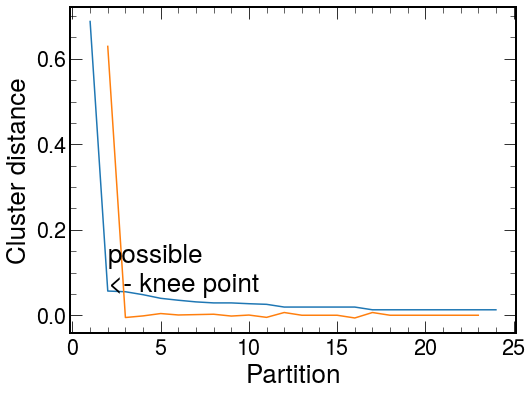

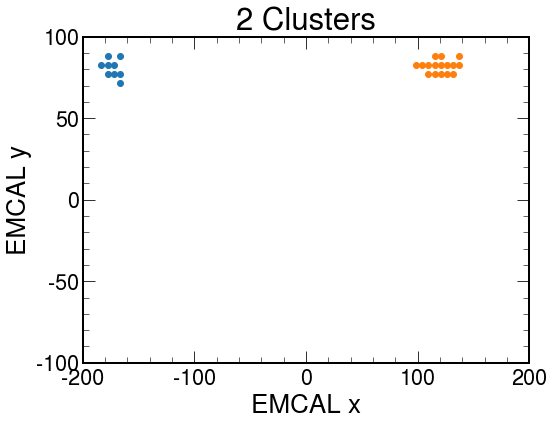

sum energy  [0.17933547, 0.46249264]
energy of electrons (genE)  [1.61, 3.82]
size of clusters ?


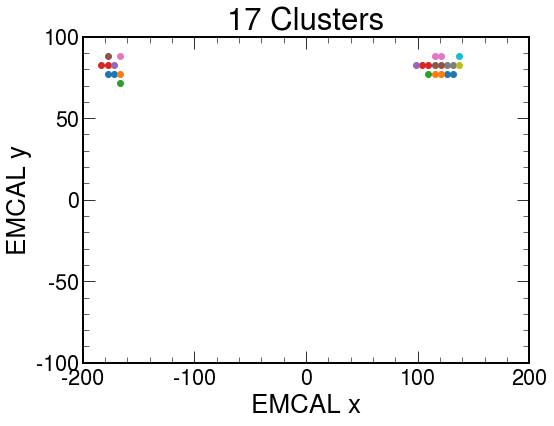

In [112]:
ifileEta = "sim_eval_Eta_0.019564_z500_600_eps_-5.2.root"
printemcalhits_byevent(ifileEta)
emcal_byevent(ifileEta,0)